In [1]:
# pip install filterpy, https://buildmedia.readthedocs.org/media/pdf/filterpy/latest/filterpy.pdf
import filterpy as fp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle as pkl

from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

import pdb

In [2]:
# Dynamics and Measurement Model Definition
nx = 5
nz = 3
dt = 0.01

def normalize_angle(ang):
    while ang >= 2 * np.pi:
        ang -= 2 * np.pi
    while ang <= - 2 * np.pi:
        ang += 2 * np.pi
    assert(ang >= -np.pi and ang <= np.pi, 'ang: %f' % ang)
    return ang

def f_cv(z, dt):
    z_new = np.zeros(nx)
    z_new[0] = z[0] + z[3] * np.cos(z[2]) * dt  #x
    z_new[1] = z[1] + z[3] * np.sin(z[2]) * dt  #y
    z_new[2] = z[2] + z[4] * dt                 #theta
    z_new[3] = z[3]                             #v
    z_new[4] = z[4]                             #omega
    return z_new
        
def h_cv(z):
    return [z[0], z[1], normalize_angle(z[2])] 

<>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-2-23ebe43c7e8a>:11: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(ang >= -np.pi and ang <= np.pi, 'ang: %f' % ang)


In [3]:
# Modified from https://github.com/rlabbe/filterpy/blob/master/filterpy/kalman/UKF.py
def state_mean(sigmas, Wm):
    assert(sigmas.shape[1] == nx)
    x = np.zeros(nx)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    for i in range(nx):
        if i is 2:
            x[i] = np.arctan2(sum_sin, sum_cos)       # angle weighted avg
        else:
            x[i] = np.sum(np.dot(sigmas[:, i], Wm)) # normal weighted avg
    return x

def z_mean(sigmas, Wm):
    assert(sigmas.shape[1] == nz)
    z = np.zeros(nz)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    for i in range(nz):
        if i is 2:
            z[i] = np.arctan2(sum_sin, sum_cos)
        else:
            z[i] = np.sum(np.dot(sigmas[:,i], Wm))
    return z

def residual_x_z(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

In [4]:
points = MerweScaledSigmaPoints(n=nx, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x_z)
ukf = UKF(dim_x=nx, dim_z=nz, fx=f_cv, hx=h_cv,
          dt=dt, points=points, x_mean_fn=state_mean, 
          z_mean_fn=z_mean, residual_x=residual_x_z, 
          residual_z=residual_x_z)

# initial state and covariance estimate
ukf.x = np.array([0., 0., 0.0, 0.0, 0.0])
ukf.P = np.eye(nx)

# process noise
ukf.Q = np.diag([1e-3, 1e-3, 1e-3, 0.1, 0.1])

# measurement noise
ukf.R = np.diag([1e-3, 1e-3, 1e-3])


In [5]:
# TODO: load in data from the rosbag
# initial position set based on spawn location
# just run this one step at a time and compare to real trajectory
# add prediction component
# IMM formulation

In [6]:
# Dubin's car example
dubins_traj = [[0., 0., 0., 10., 0.01]]
for i in range(50):
    dubins_traj.append( f_cv(dubins_traj[-1], dt) )
for i in range(50):
    if i == 0:
        dubins_traj[-1][4] = -0.01
    dubins_traj.append( f_cv(dubins_traj[-1], dt) )
for i in range(50):
    if i == 0:
        dubins_traj[-1][4] = 0.
    dubins_traj.append( f_cv(dubins_traj[-1], dt) )
    
dubins_traj = np.array(dubins_traj)
    
    

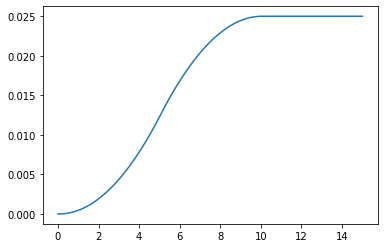

In [7]:
import matplotlib.pyplot as plt

plt.plot(dubins_traj[:,0], dubins_traj[:,1])

Text(0.5, 1.0, 'Angular Velocity')

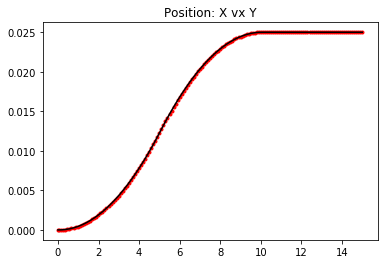

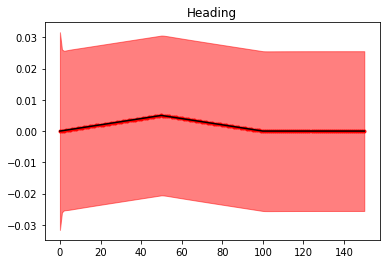

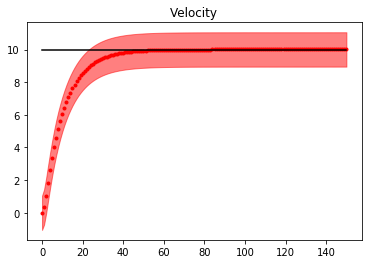

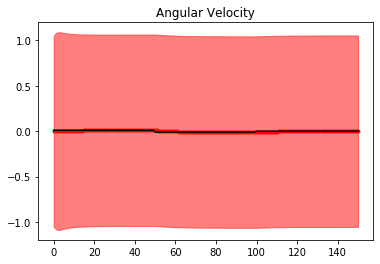

In [8]:
np.set_printoptions(precision=2)
xfilt = []; xfiltstd = []
ukf.x[:3] = dubins_traj[0,:3]
for i in range(len(dubins_traj)):
    ukf.predict()
    ukf.sigmas_f = ukf.points_fn.sigma_points(ukf.x, ukf.P) # see https://github.com/rlabbe/filterpy/issues/172
    ukf.update(dubins_traj[i,:3])
    xfilt.append(ukf.x.copy())
    xfiltstd.append(np.sqrt(np.diag(ukf.P)))
    
# xpred = []
# for i in range(50):
#     ukf.predict()
#     xpred.append(ukf.x.copy())

xfilt = np.array(xfilt)
xfiltstd = np.array(xfiltstd)

#pdb.set_trace()
# xpred = np.array(xpred)

plt.figure()
plt.plot(xfilt[:,0], xfilt[:,1], 'r.')
#plt.plot(xpred[:,0], xpred[:,1], 'c')
plt.plot(dubins_traj[:,0], dubins_traj[:,1], 'k')

plt.title('Position: X vx Y')

plt.figure()
plt.plot(xfilt[:,2], 'r.')
below = xfilt[:,2] - xfiltstd[:,2]
above = xfilt[:,2] + xfiltstd[:,2]
plt.fill_between(np.arange(xfilt.shape[0]), below, above, color='r', alpha=0.5)
#plt.plot(xpred[:,2], 'c')
plt.plot(dubins_traj[:,2], 'k')
plt.title("Heading")

plt.figure()
plt.plot(xfilt[:,3], 'r.')
below = xfilt[:,3] - xfiltstd[:,3]
above = xfilt[:,3] + xfiltstd[:,3]
plt.fill_between(np.arange(xfilt.shape[0]), below, above, color='r', alpha=0.5)
#plt.plot(xpred[:,3], 'c')
plt.plot(dubins_traj[:,3], 'k')
plt.title("Velocity")

plt.figure()
plt.plot(xfilt[:,4], 'r.')
below = xfilt[:,4] - xfiltstd[:,4]
above = xfilt[:,4] + xfiltstd[:,4]
plt.fill_between(np.arange(xfilt.shape[0]), below, above, color='r', alpha=0.5)
#plt.plot(xpred[:,4], 'c')
plt.plot(dubins_traj[:,4], 'k')
plt.title("Angular Velocity")

